# 迁移学习
在本笔记本中，您将学习如何使用**预训练的网络(pre-trained networks)**来解决计算机视觉中的难题。 具体来说，您将使用torchvision提供的ImageNet**培训的**网络。 [ImageNet](http://www.image-net.org/) [available from torchvision](http://pytorch.org/docs/0.3.0/torchvision/models.html).   
+ Docs » torchvision » torchvision.models

**ImageNet是一个庞大的数据集**，在1000个类别中有超过100万张带标签的图像。 它用于使用称为卷积层的体系结构来训练深度神经网络。 在这里，我将不涉及卷积网络的详细信息，卷积神经网络将在下一章学习。

一旦经过训练，这些模型/神经网络就可以出色地工作像图像特征检测器一样在它没有训练过的数据集上工作。 **对不在训练集中的图像使用预先训练的网络(a pre-trained network)称为转移学习**。 在这里，我们将使用转移学习来训练一个网络，来完美地对猫和狗的照片进行分类。   

使用`torchvision.models`，可以下载这些(pytorch中的)经过预训练的网络，并在自己的应用中使用它们
+ 现在，我们将在我们的` import` 导入这些 `models`。查看官网torchvision.models可以知道有6个architechtures可以， 使用包括AlexNET,VGG,DenseNet等

## 0. 前提准备

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt


import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

## 1. 加载数据集

加载自己的数据集，根据要求做数据的 transform
+ 大多数 pretrained models 要求的输入都是 224x224 的图像
+ 另外，我们也需要匹配训练模型时使用的归一化：每个颜色通道分别进行归一化：
  + the means are [0.485, 0.456, 0.406] and the standard deviations are [0.229, 0.224, 0.225]

In [8]:
data_dir = r'D:\Jupyterlab_data\Cat_Dog_data' 

# TODO: 将在数据时为 train data 和 testing data 分别定义数据转换
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(224), 
                                      transforms.CenterCrop(224),
                                       transforms.ToTensor(), 
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

# 使用定义的数据转换方式生成数据集
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/train', transform=test_transforms)

# 加载数据集
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

## 2. 模型准备

+ 现在我们从 `torchvision.models` 引用一个模型例如 **DenseNet(http://pytorch.org/docs/0.3.0/torchvision/models.html#id5)**
+ 我们导入后查看一下这个模型的结构：121代表有121个layers

In [9]:
model = models.densenet121(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\123/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

简单理解一下，这个网络主要分为两个大块 `features`部分和 `classifier` 部分：
+ `features` 部分是一堆卷积层(a stack of convolutional layers)并整体作为一个**特征检测器**工作，结果可以输入到一个 classifier

```python
vgg = models.vgg19(pretrained=True).features
```

+ `classifier` 分类器部分是一层全连接层   

```python
(classifier): Linear(in_features=1024, out_features=1000)
```   
 + 这一层(全连接层，分类器)是在ImageNet数据集上训练的，因此它**不能**用于我们的不同的问题。这意味着我们需要更换网络的classifier部分，但是 features 特征检测部分可以很好的工作   
 
总的来说，预训练网络(pre-trained netwoeks)被认为是出色的特征检测器，可以用作简单前馈分类器(feed-forward)的输入

---
## Pytorch 语法1 冻结模型参数 `.requires_grad=` + 自定义预训练网络的classifier
我们下面要做的就是保留/不更新这个网络的features部分的参数，retrain classifier部分的参数：
1. 冻结feature parameters
  + 遍历模型(特征提取器部分)的参数
  + 执行 `param.requires_grad = False`：实现当我们通过网络计算时，it's not going to calculate the gradient：
    + 在第5节我们在验证参数时候使用的是 `with torch.no_grad():` 关闭梯度/操作追踪的
    + 这样就保证 our **feature parameters** 不会更新，同时能够提高训练速度
  + **注：根据下面`model.classifier`表示分类器部分这里 `model.parameters()` 就仅仅指features部分的参数？**     


2. 替换这个模型中的 classifier：replace the classifier with our own classifier
  + 使用Pytorch的`Sequential`模块定义一个classifer结构：给它一个要执行的**不同operations的列表**(a list of different operations you want to do)，然后classifer将自动按顺序 pass a tensor through them:
  + 这些有序操作用有序字典创建可以给网络的层命名：you can pass in an ordered dict to name each of these layers
  + 即定义一个小型的全连接网络含输出层

## Pytorch 语法2 python 容器：有序字典
```python 
class collections.OrderedDict([items])
```
> https://www.cnblogs.com/zhenwei66/p/6596248.html
+ 输入是一个列表类型，列表的元素是元组类型，元组的两个元素是键值对

In [11]:
# 首先冻结导入模型的！参数！
for param in model.parameters():
    param.requires_grad = False
    
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                            ('fc1', nn.Linear(1024, 500)),    # feature部分的输出是1024
                            ('relu', nn.ReLU()),
                            ('fc2', nn.Linear(500, 2)), 
                            ('output', nn.LogSoftmax(dim=1))
                          ]))

# 更换导入的模型的分类器部分！
model.classifier = classifier

In [12]:
model.classifier

Sequential(
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=500, out_features=2, bias=True)
  (output): LogSoftmax(dim=1)
)

## Pytorch 语法3 使用cuda训练   


再理解
+ 导入数据集，注意定义对应的transfors
+ 导入预训练的模型
+ 冻结模型参数+自定义分类器+替换模型分类器


**接下来：建立模型后，我们需要训练这个模型 -- 实际上是使用我们的数据集仅训练`classifier`部分的参数。**

但是，现在我们正在使用真正的深度神经网络。 如果您尝试像以前那样在CPU上进行训练，这将需要很长时间。instead，我们将使用GPU进行计算。在GPU上线性代数计算是并行完成，从而使训练速度可以提高了100倍。而且还可以在多个GPU上进行训练，从而进一步减少了训练时间。PyTorch和几乎所有其他的深度学习框架一样，使用[CUDA](https://developer.nvidia.com/cuda-zone)高效地计算GPU向前和向后的传递(forward and backwards passes)。

+ 在PyTorch中，可以使用 `model.to('cuda')` 将模型参数(model parameters)和其他张量移动到GPU内存中,
+ 可以用 `model.to('cpu')` 将它们从GPU移回来，这通常是你需要在PyTorch之外对网络输出进行操作时需要做的   

为了说明速度的提高，下面将比较在有无GPU的情况下执行向前和向后传递所需的时间。
+ 注 `model.classifier.parameters()` 表示model的分类器部分的参数

In [13]:
import time

也可以使用 
+ `model.cuda()` 或者 `images.cuda()` 等移入GPU
+ 使用 `model.cpu` 返回cpu

In [14]:
for device in ['cpu', 'cuda']:

    criterion = nn.NLLLoss()
    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

    model.to(device)                                               # model.cuda()

    # 训练过程
    for ii, (inputs, labels) in enumerate(trainloader):

        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)      # inputs.cuda() labels.cuda()

        start = time.time()
        
        # 计算前向输出，计算损失，计算梯度，更新梯度
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if ii==3: # 统计前3循环
            break
        
    print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")

Device = cpu; Time per batch: 2.719 seconds
Device = cuda; Time per batch: 0.010 seconds


我们可以查看是否可以在pytorch中使用本机的GPU

In [15]:
torch.cuda.is_available()

True

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

于是实际上我们可以编写与设备无关的代码，让它判断能否使用cuda，如果启用了该代码，它将自动使用CUDA，如下所示：   
```python
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

...

# then whenever you get a new Tensor or Module
# this won't copy if they are already on the desired device
input = data.to(device)
model = MyModule(...).to(device)
```

现在我们将自己完成模型的训练/trainingtraining。 除了现在您的模型功能更强大之外，该过程与之前相同(The process is the same as before)。 您应该轻松获得优于95％的精度。

---
**Exercise:** 训练一个预训练模型(a pretrained modelsa pretrained models)对猫和狗的图像进行分类。 继续使用DenseNet模型，或尝试使用ResNet，这也是可以用来尝试的好模型。保仅训练分类器参数，features part的参数已冻结
+ Make sure you are **only training the classifier** and the parameters for the features part are frozen

## 3. 训练过程
TODO: Use a pretrained model to classify the cat and dog images   
0. 导入必要的库
1. 数据准备

2. 导入预训练模型+编写新分类器->模型准备   
3. **训练过程**

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt


import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [3]:
data_dir = r'D:\Jupyterlab_data\Cat_Dog_data' 

# TODO: 将在数据时为 train data 和 testing data 分别定义数据转换
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255), 
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(), 
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

# 使用定义的数据转换方式生成数据集
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

# 加载数据集
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

【注】在设置test数据的transform时候，一开始只设置了 `transforms.Resize(224)` 没有设置 `transforms.CenterCrop(224)` 结果运行的时候报错   
```python 
RuntimeError: stack expects each tensor to be equal size, but got [3, 237, 224] at entry 0 and [3, 224, 400] at entry 1
```

区分两个：
+ `torchvision.transforms.Resize(size, interpolation=2)`
  + size (sequence or int) – Desired output size. If size is a sequence like (h, w), output size will be matched to this. If size is an int, smaller edge of the image will be matched to this number. i.e, if height > width, then image will be rescaled to (size * height / width, size). 
+ `torchvision.transforms.CenterCrop(size)`
 + size (sequence or int) – Desired output size of the crop. If size is an int instead of sequence like (h, w), a square crop (size, size) is made.

**3. 模型准备(OK)**
+ 注意替换对应的全连接层的方法！对于`densenet121`网络，通过查看model知道最后的分类器的名字是 `classifier` 因此用 `model.classifier`来替换，而例如 `resnet50`，下载查看后它的最后一层的名字是`fc`则需要使用 `model.fc=classifier`来替换！

In [5]:
# 在代码最开始判断GPU是否可用
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.densenet121(pretrained=True)

for params in model.parameters():
    params.requires_grad = False 
    
# 灵活使用定义网络结构：这里只要结构？    
from collections import OrderedDict

classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1024, 500)),
    ('relu1', nn.ReLU()),
    ('dropout', nn.Dropout(p=0.2)),
    ('fc2', nn.Linear(500, 2)),
    ('output', nn.LogSoftmax(dim=1)) #易错
]))
# 更换导入的模型的分类器部分！
model.classifier = classifier


# 参考答案
# model.classifier = nn.Sequential(nn.Linear(1024, 256),
#                                  nn.ReLU(),
#！                                nn.Dropout(0.2),
#                                  nn.Linear(256, 2),
#                                  nn.LogSoftmax(dim=1))

# 分号表示不打印结果
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

**4. 训练过程**  
【较严重的错误】 ！   
将验证部分的代码与 `for images, labels in trainloader:` 部分并列，没理解到 `for images, labels in trainloader:` 的一次遍历表示取一个batch_size的数据(64条):   

 + `steps += 1` 记录对于全部的数据-`trainloader`执行了几次取batch训练 == len(train_loader)//batch_size+1 假设不能正好整除 
 
 + `running_loss += loss.item()` 代表累计每个 batch的训练误差，但这里不是一个，见下   
 
 + `if steps % print_every == 0:` 这与上一章的代码不同在于，这里想做的是对于整个数据集，每5个batch就输出一次精确度，训练损失，测试损失，因此这块代码是从属于`for images, labels in trainloader:`内的！   
 
 + 上一节的代码是对每一个 epoch 输出一次损失与精确度，因此需要在执行完`for images, labels in trainloader:`之后累计了全部的训练损失，并且经过1个epoch的数据更新完参数之后，在来执行验证部分代码求测试损失和精确度，则该部分代码在for之外。   
 
另外一个点：
+ 经过比较对于使用`nn.Sequential()` 和 `class()` 定义的网络都可以使用这两种前向计算的方法：
 + `model(images)`
 + `model.forward(images)`

In [4]:
# Only train the classifier parameters, feature parameters are frozen
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

epochs = 1
steps = 0
running_loss = 0
print_every = 5

train_losses, test_losses = [], []
for e in range(epochs):
    # running_loss = 0 现在不是求epoch的loss
    for images, labels in trainloader:
        # running_loss = 0 放这里是错误的，因为这样在 if 输出的是每第5个batch的损失
        steps += 1
        images = images.to(device)
        labels = labels.to(device)
        #!
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        
        optimizer.step()
        #! 注当，running_loss 没有归0的时候一直累加，而在 if结尾
        # 归0，表示统计每5个batch的累计损失
        running_loss += loss.item()
        
    
    # 验证部分
    # 梅5个batches验证一次 
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0

            model.eval() # 关闭dropout
            with torch.no_grad():
                for images, labels in testloader:
                    images, labels = images.to(device), labels.to(device)
                    
                    log_ps = model(images)
                    # 测试误差：在经过5个batch训练之后的
                    loss = criterion(log_ps, labels)
                    test_loss += loss.item()
                    
                    ps = torch.exp(log_ps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()       
            model.train()
            
            print('Epoch {}/{}..'.format(e+1, epochs), 
                  'Train loss(every 5 batches):{:.3f}..'.format(running_loss/print_every), 
                  'Test loss:{:.3f}..'.format(test_loss/len(testloader)), 
                  'Test accuracy:{:.3f}..'.format(accuracy/len(testloader)))
            
            
            # 把每5个的损失添加到列表中用于作图
            train_losses.append(running_loss/print_every)
            test_losses.append(test_loss/len(testloader))
            running_loss = 0 # 打印了5个batch的损失后，归0, 一定放在print之后！



Epoch 1/1.. Train loss(every 5 batches):1.364.. Test loss:0.308.. Test accuracy:0.958..
Epoch 1/1.. Train loss(every 5 batches):0.475.. Test loss:0.196.. Test accuracy:0.973..
Epoch 1/1.. Train loss(every 5 batches):0.342.. Test loss:0.163.. Test accuracy:0.947..
Epoch 1/1.. Train loss(every 5 batches):0.298.. Test loss:0.090.. Test accuracy:0.977..
Epoch 1/1.. Train loss(every 5 batches):0.217.. Test loss:0.079.. Test accuracy:0.975..
Epoch 1/1.. Train loss(every 5 batches):0.153.. Test loss:0.073.. Test accuracy:0.977..
Epoch 1/1.. Train loss(every 5 batches):0.117.. Test loss:0.074.. Test accuracy:0.972..
Epoch 1/1.. Train loss(every 5 batches):0.164.. Test loss:0.053.. Test accuracy:0.980..
Epoch 1/1.. Train loss(every 5 batches):0.171.. Test loss:0.055.. Test accuracy:0.980..
Epoch 1/1.. Train loss(every 5 batches):0.259.. Test loss:0.050.. Test accuracy:0.982..
Epoch 1/1.. Train loss(every 5 batches):0.166.. Test loss:0.049.. Test accuracy:0.982..
Epoch 1/1.. Train loss(every 5 b

KeyboardInterrupt: 

作图

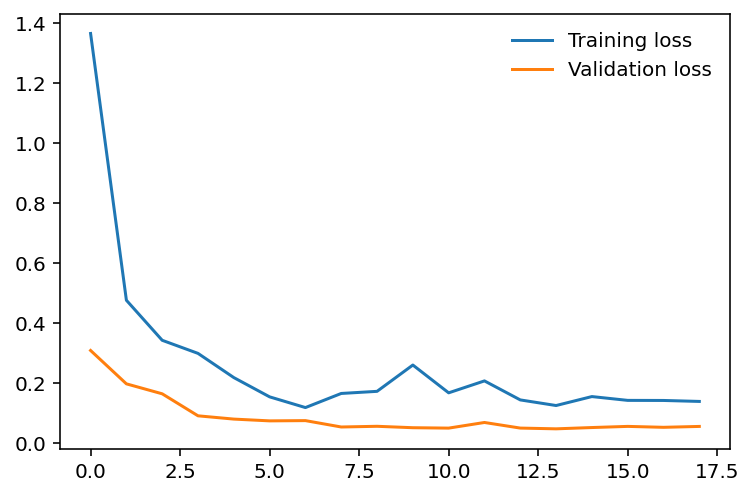

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False) 

In [6]:
print(train_losses)

[1.3636512219905854, 0.474934321641922, 0.34151611328125, 0.29788961410522463, 0.21728209257125855, 0.1530622661113739, 0.11735874339938164, 0.16438999325037001, 0.1714396983385086, 0.25910759419202806, 0.16647679954767228, 0.20621921718120576, 0.14288083612918853, 0.12417926341295242, 0.1540110945701599, 0.14134971499443055, 0.141057388484478, 0.137833634018898]


应用：下面的是给1通道的可视化的3通道？

In [8]:
# Import helper module (should be in the repo)
import helper

# Test out your network!

# 关闭dropout
model.eval()

# 从测试集中搞一个
dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
img.shape

torch.Size([3, 224, 224])

In [13]:
img = img.view(64, 3, 7, 7)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(3, 224, 224), ps, version='Fashion')

RuntimeError: shape '[64, 3, 7, 7]' is invalid for input of size 150528

In [ ]:
# Import helper module (should be in the repo)
import helper

# Test out your network!

# 关闭dropout
model.eval()

# 从测试集中搞一个
dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')

trainloader里面一共有多少图 每次64 

再写